# Introduction

In this notebook, I go over some visualizations of the iceberg data. My purpose here is not to set up a classifier, but rather to try to get some sense of what types of features might be most useful.

As usual, we first have to import some packages.

在这个笔记本中，我将展示一些冰山数据的可视化。我的目的不是建立一个分类器，而是尝试了解哪些类型的特征可能最有用。

像往常一样，我们首先需要导入一些包。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I'll now read in the file. It is in a .json format rather than the .csv format that seems to be most common on Kaggle. It also turns out that "inc_angle" has some bad values, so I will convert it to a floating point format with the NaN values left in.

In [2]:
train = pd.read_json('input/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

# Global Image Stats

Now, I will look at some global properties of the images. These are things like the minimum and maximum values, the means, medians, and the 50% mid range of the signal values. There are two different bands used in the file, so I'll do this separately for each band.

现在，我将查看图像的一些全局属性。这些属性包括最小值和最大值、平均值、中位数以及信号值的 50% 中间范围。文件中使用了两个不同的波段，所以我会分别对每个波段进行分析。

In [3]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

## Plotting the Statistics

Now, we can make some histograms of these variables. I'll make histograms of both classes to see if there are any differences.

现在，我们可以制作这些变量的直方图。我将分别为两个类别制作直方图，以查看它们之间是否存在差异。

In [4]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

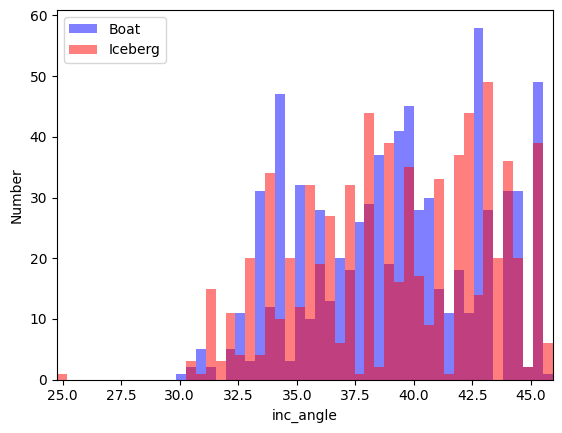

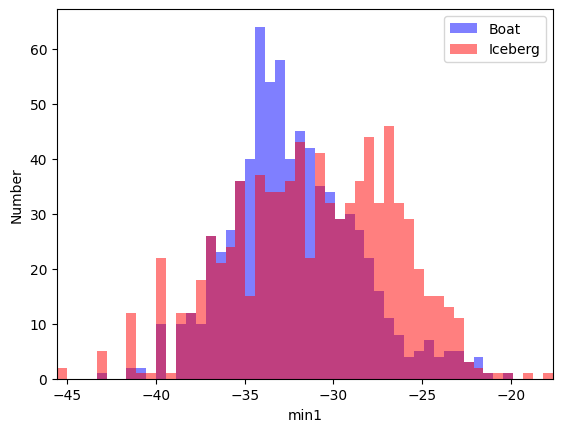

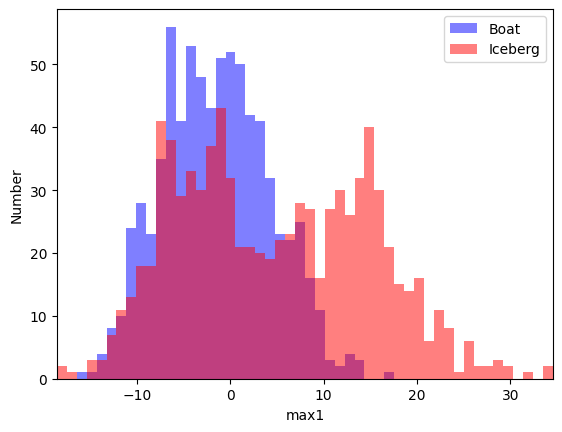

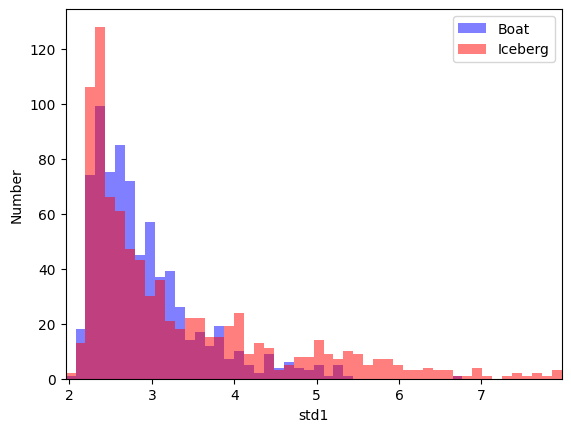

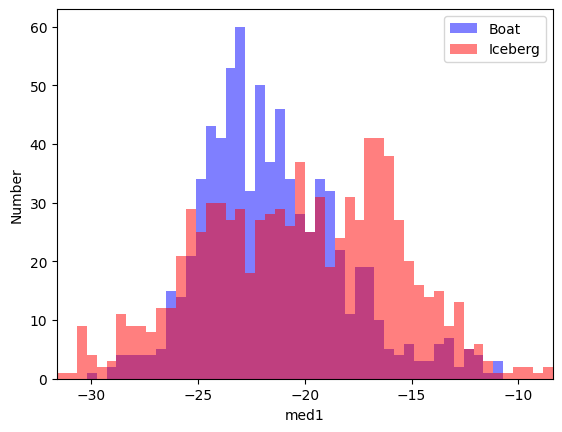

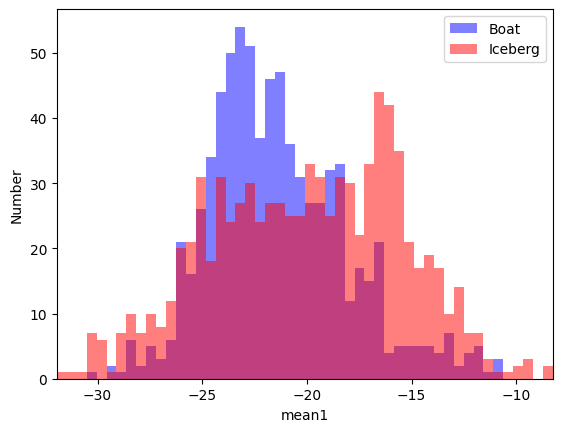

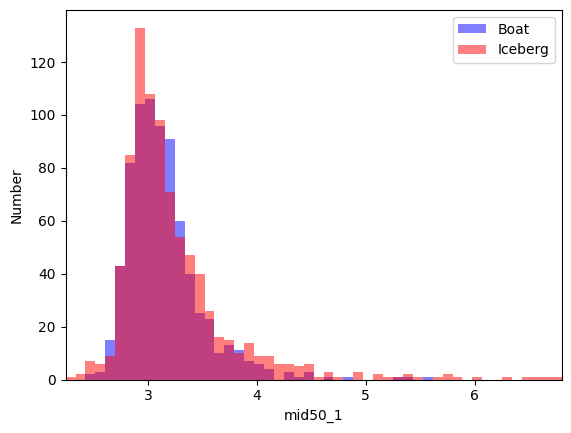

In [5]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)


For the first band, we see that there are some significant differences. The middle 50% range has around the same size for both, but the minimum, maximum, standard deviation, median, and mean all show noticeable differences in some range of the values. Evidently, these basic variables seem to have some sensitivity to what we are trying to measure. We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

对于第一个波段，我们看到存在一些显著差异。两类数据的中间 50% 范围大致相同，但最小值、最大值、标准差、中位数和平均值在某些值范围内均显示出明显差异。显然，这些基本变量对我们试图测量的内容具有一定的敏感性。例如，如果冰山比船只大得多，它们可能会覆盖更多的像素，我们可能会预期这种差异。

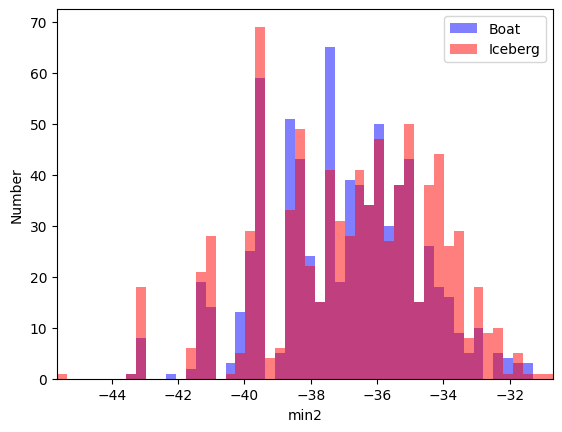

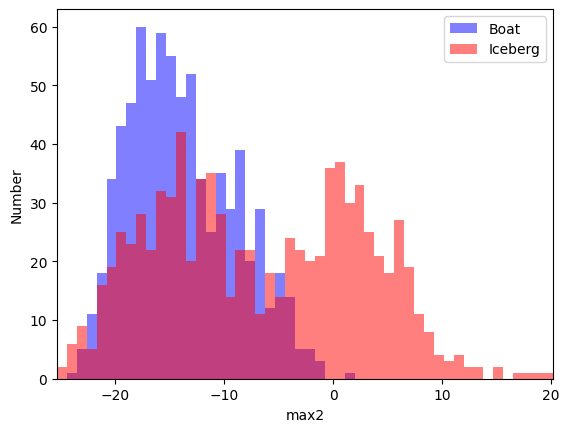

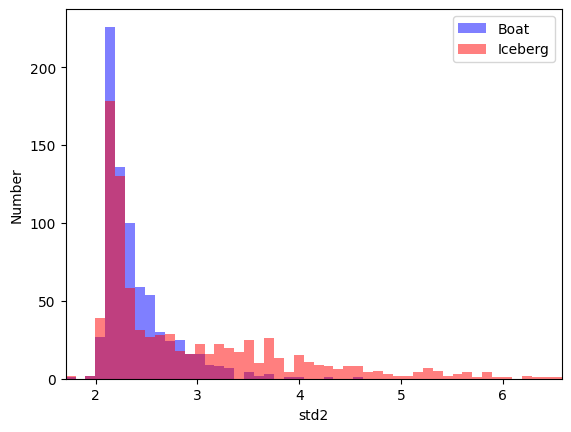

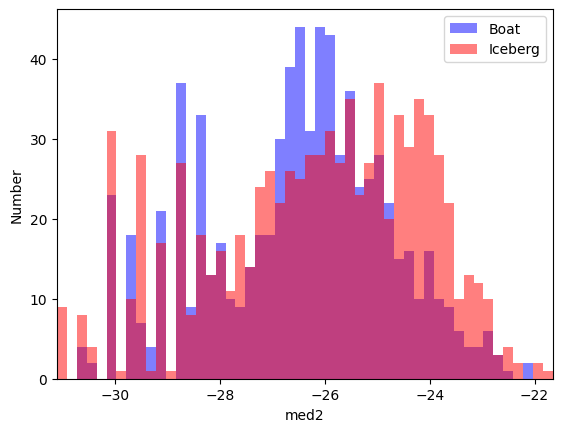

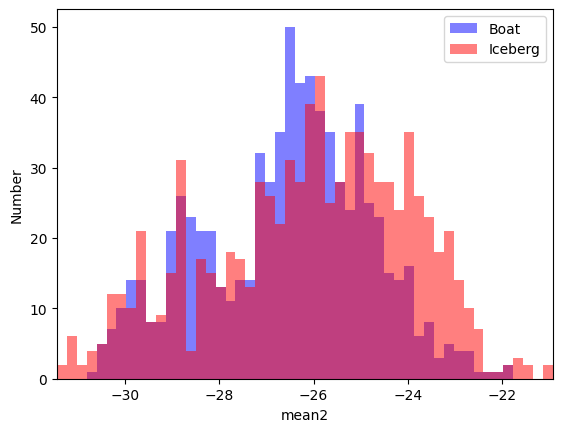

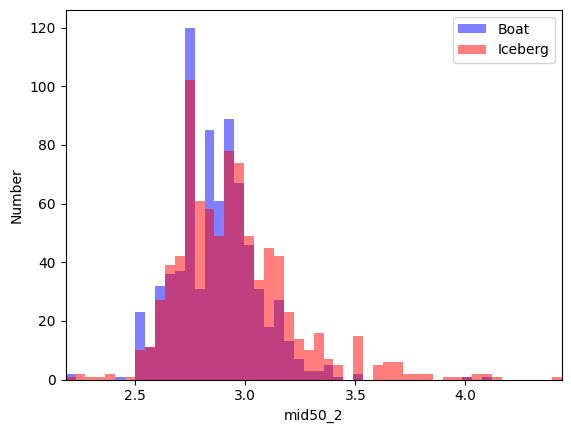

In [6]:
for col in ['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

We get similar results for the second band.

对于第二个波段，我们得到类似的结果。

## Correlations Between Features

Now that we've established that these variables may have some use, we should look at the correlations between them. For this, I'll just plot the correlation matrix. It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn), but i won't do that here.

特征之间的相关性

既然我们已经确定这些变量可能有用，我们应该看看它们之间的相关性。为此，我将绘制相关矩阵。同样，查看每对变量的散点图也是有益的（这可以在 Seaborn 中轻松完成），但这里我不会进行散点图的绘制。

In [7]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

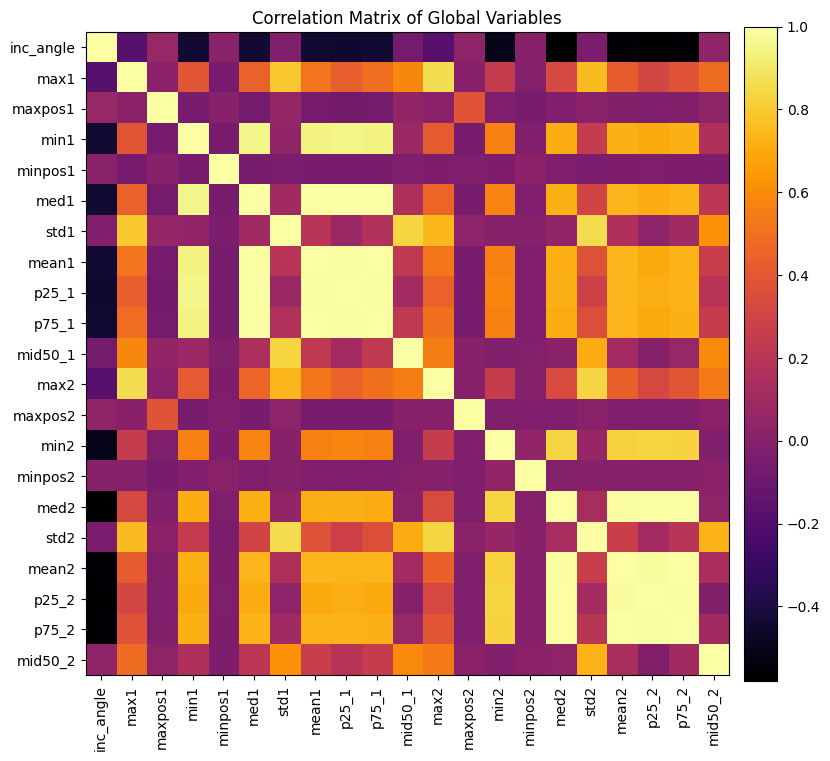

In [8]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

We see that there are large correlations between some of the variables. In particular, the mean, median, 25% signal, and 75% signal are all closely related, with nearly 75% correlation. The min and max are also pretty highly correlated for band 1, as are the min and median for both bands, suggesting that the signals have maybe been scaled in some way to force this correlation. There are also some correlations between the two bands. Finally, we see an anticorrelation of around -0.5 between the mean of band 2 and the angle, with a weaker correlation for band 1.

我们看到一些变量之间存在较大的相关性。特别是平均值、中位数、25%信号和75%信号之间都密切相关，相关性接近75%。对于波段1，最小值和最大值也高度相关，而两个波段的最小值和中位数也存在高度相关性，这表明信号可能以某种方式进行了缩放以强制这种相关性。两个波段之间也存在一些相关性。最后，我们看到波段2的平均值与角度之间存在大约-0.5的负相关，而波段1的相关性较弱。

# Plotting Some Images

It's good to plot some images before we do too much analysis. That way, we can get some sense of what we're looking at. The images are 75 x 75 pixels each with two bands.

绘制一些图像

在进行过多分析之前，绘制一些图像是有益的。这样我们可以大致了解我们正在查看的内容。图像每个有75 x 75像素，包含两个波段。

In [9]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

## Raw Images

The first set show 9 random icebergs using band 1.

原始图像

第一组图像显示了使用波段1的9个随机冰山。

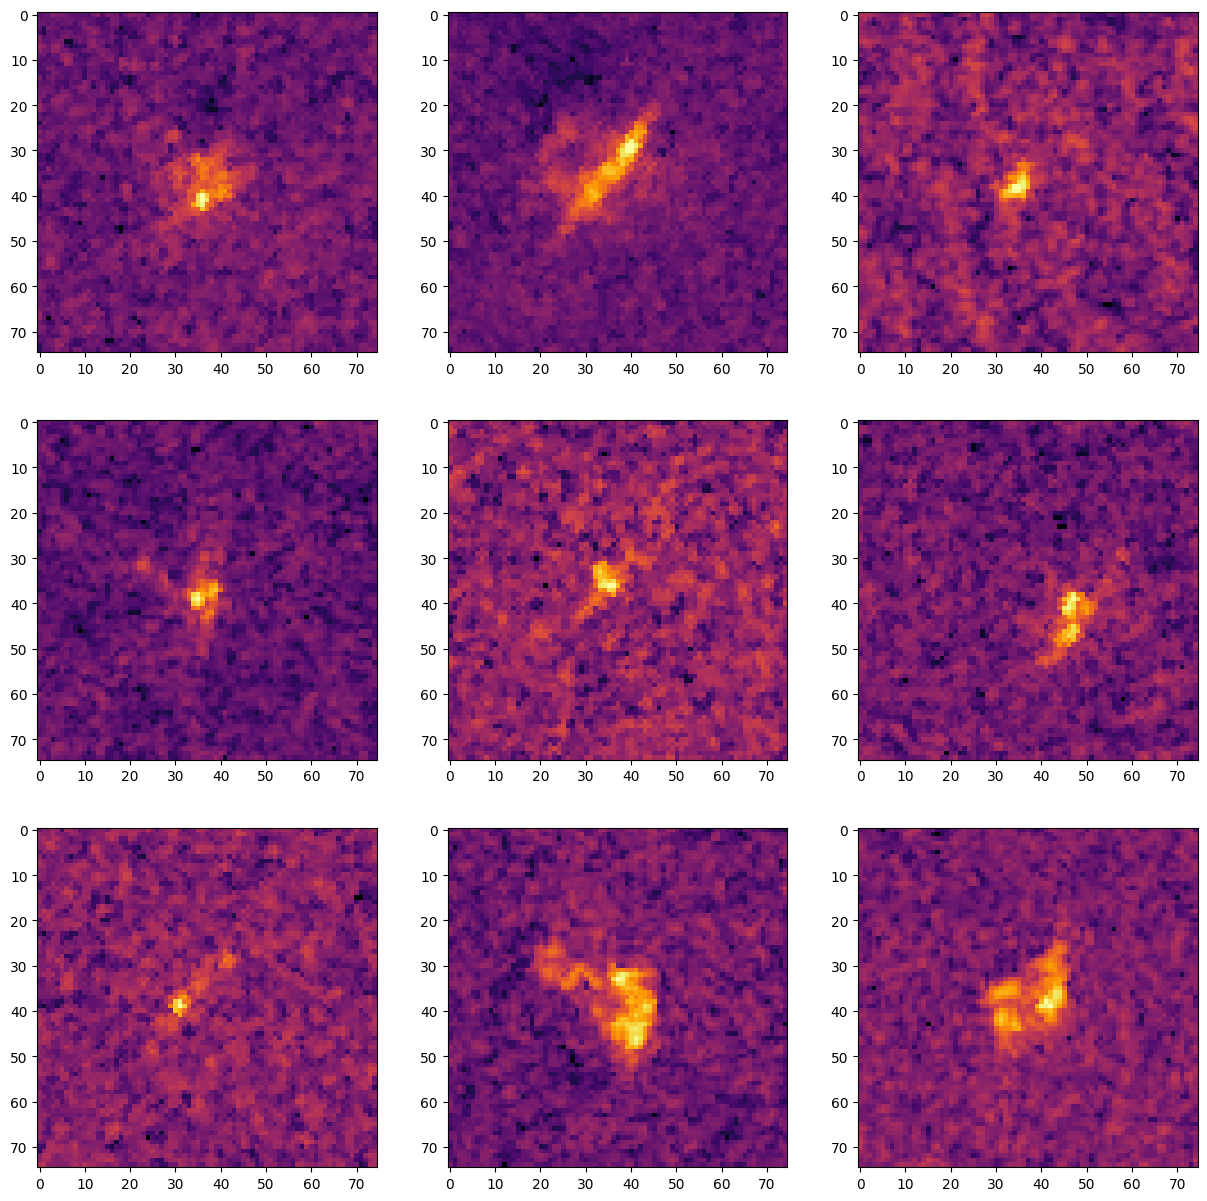

In [10]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The second set shows ships in band 1.

第二组图像显示了波段1中的船只。

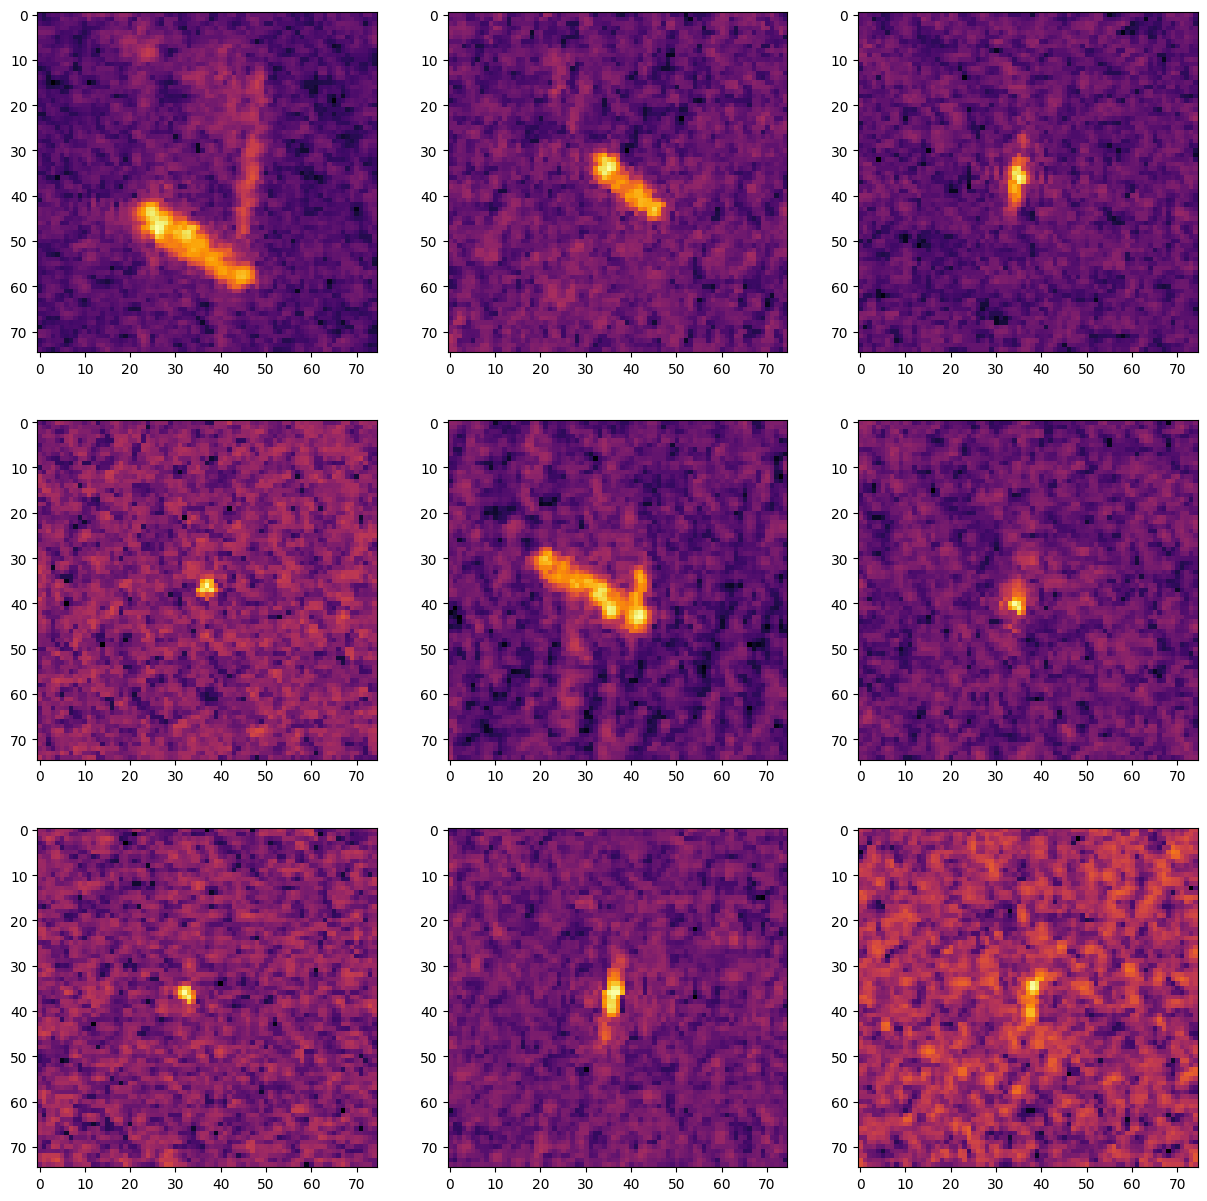

In [11]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The next set show the same set of icebergs in band 2.

接下来这一组图像显示了相同冰山在波段2中的情况。

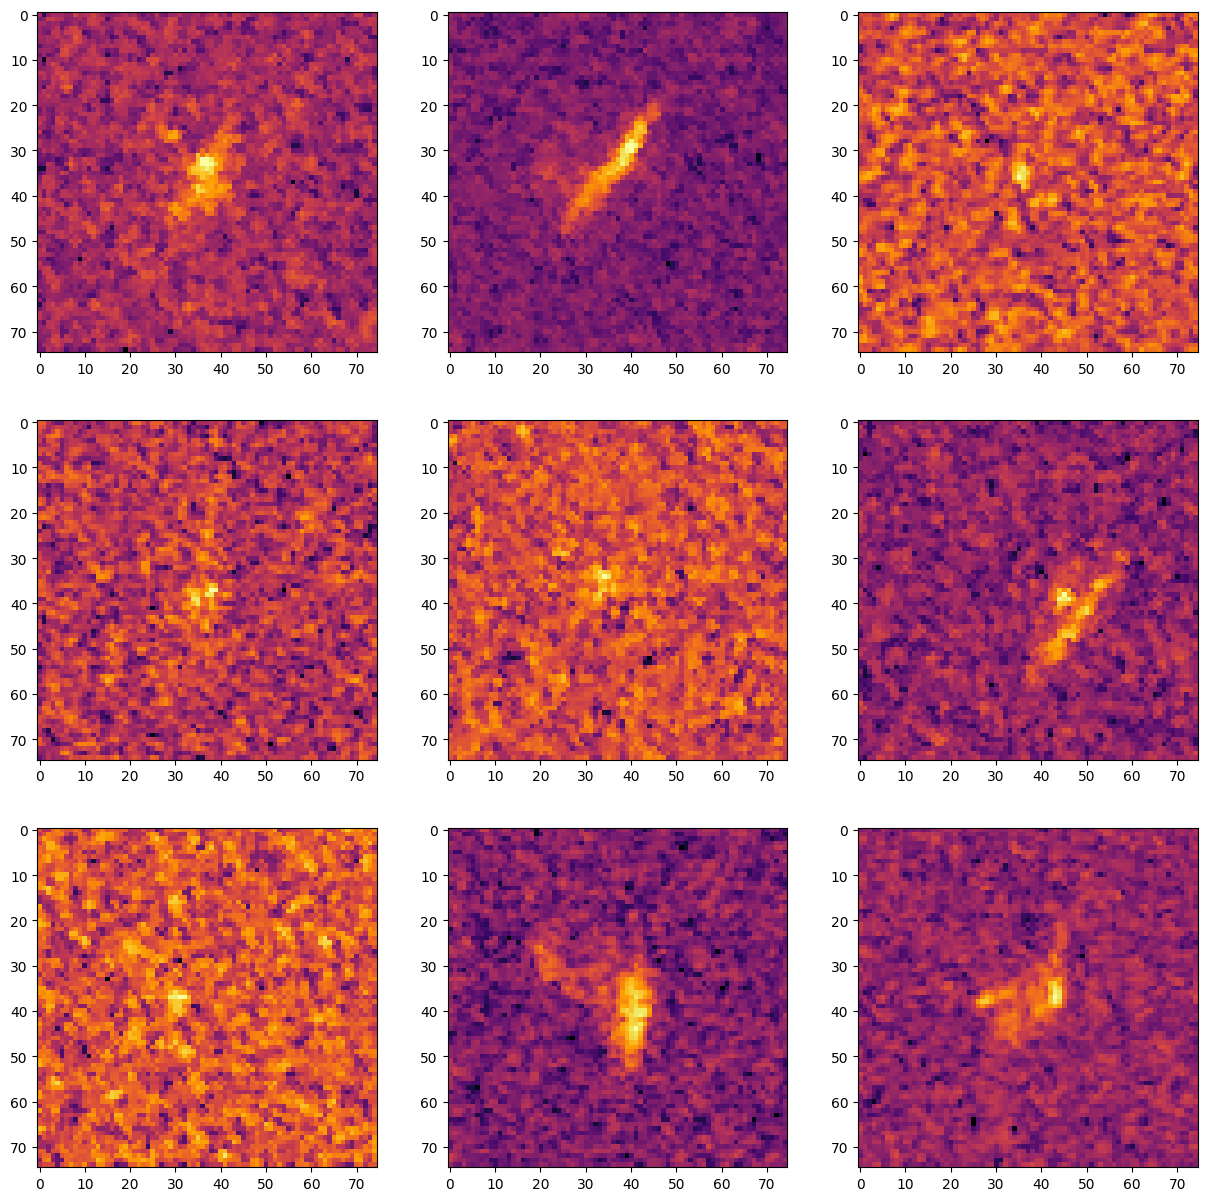

In [12]:
# Plot band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,2]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

Finally, the last set are the same ship images as before, but for band 2.

最后一组图像是之前相同的船只图像，但显示的是波段2中的情况。

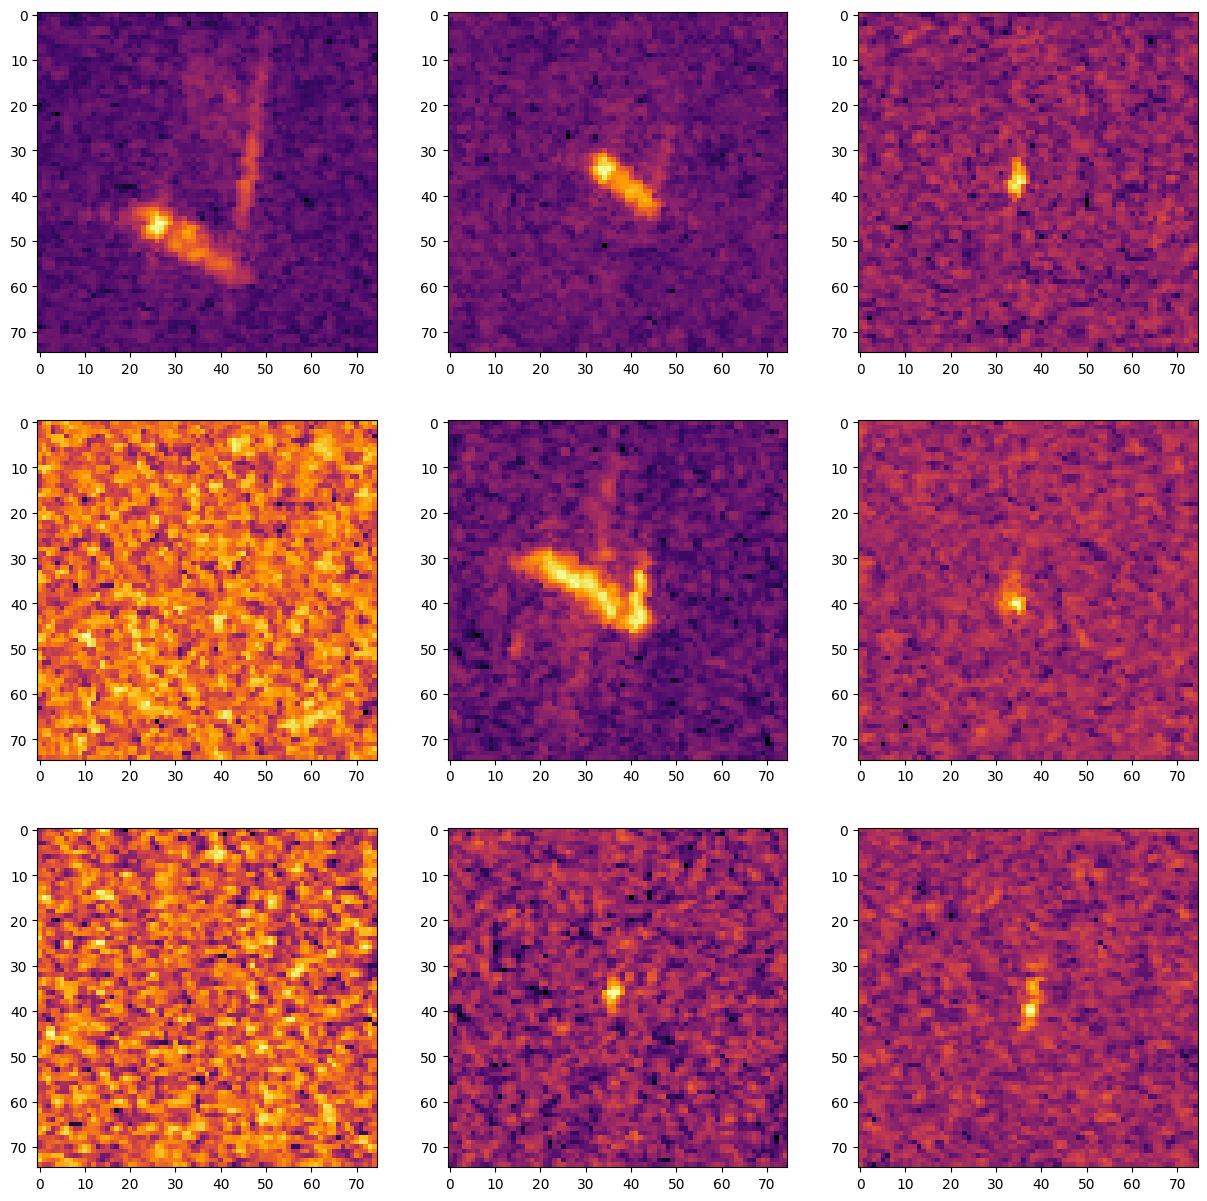

In [13]:
# Plot band_2
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,2]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

So, we see that everything looks pretty blob-like. It also appears that the background is not really random noise but rather has some spatial correlations. If the background is dominated by things like waves rather than noise, then spatial correlations would clearly be expected. The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals.

Some of these blobs are not that high above noise, and in the last set there are even two images where the signal cannot even be seen by eye, so it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

所以，我们看到所有图像看起来都像是一些模糊的斑点。此外，背景似乎并不是随机噪声，而是具有一定的空间相关性。如果背景主要是由波浪等因素主导而不是噪声，那么显然会有空间相关性。船只似乎有更规则的结构，对于较大信号的斑点有明显的偏斜。

有些斑点并不比噪声高出太多，在最后一组中甚至有两幅图像中的信号肉眼无法看见，因此，首先以某种方式转换图像以增强信号和背景之间的对比可能是有利的。

# Transforming the Images

I'll look at a few types of basic transforms that can be easily defined by FIR filters. The scipy convolve2d function will run a convolution of two arrays, so we just need to define the kernels. I have not optimized the kernels here, and there are many other choices of types of kernels, so you should try out different options to see what they do.


**转换图像**

我将查看几种可以通过有限脉冲响应（FIR）滤波器轻松定义的基本转换类型。scipy的convolve2d函数将对两个数组进行卷积，因此我们只需要定义核。我这里没有优化核，还有许多其他类型的核可以选择，因此你应该尝试不同的选项以了解它们的效果。

In [14]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

### Smoothing

First, let's try smoothing the images. The kernel here just has all positive values and is symmetric in both directions.

I'll first plot the icebergs and then the ships. These are all for Band 1.

平滑

首先，让我们尝试对图像进行平滑处理。这里的核具有所有正值，并且在两个方向上都是对称的。

我将先绘制冰山图像，然后绘制船只图像。这些图像都使用波段1的数据。

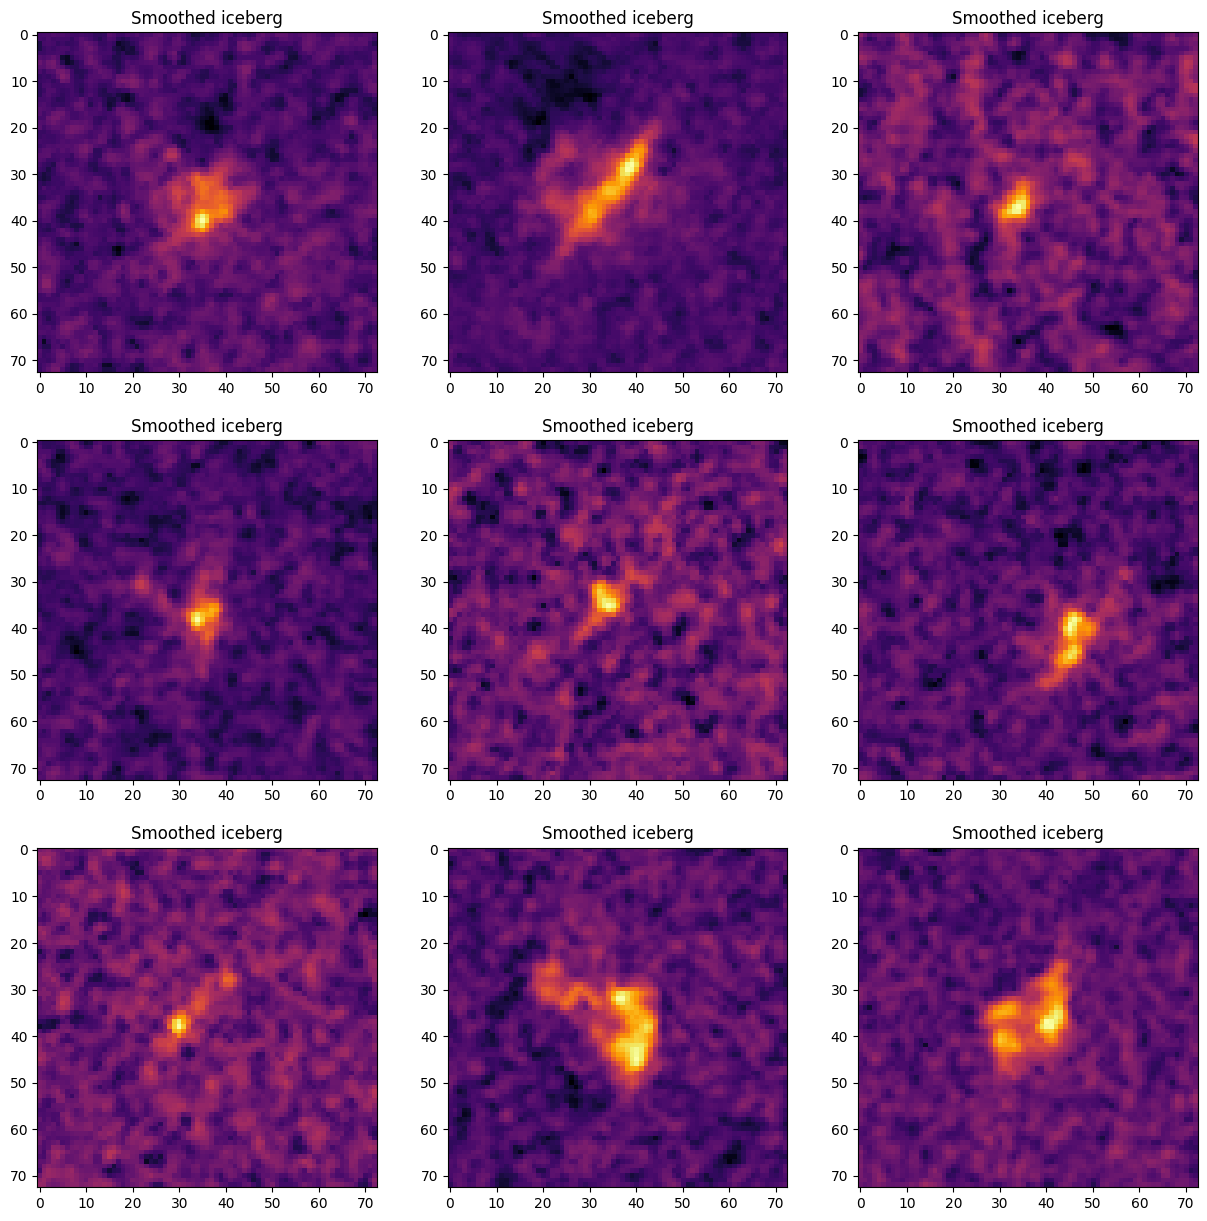

In [15]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed iceberg')

plt.show()

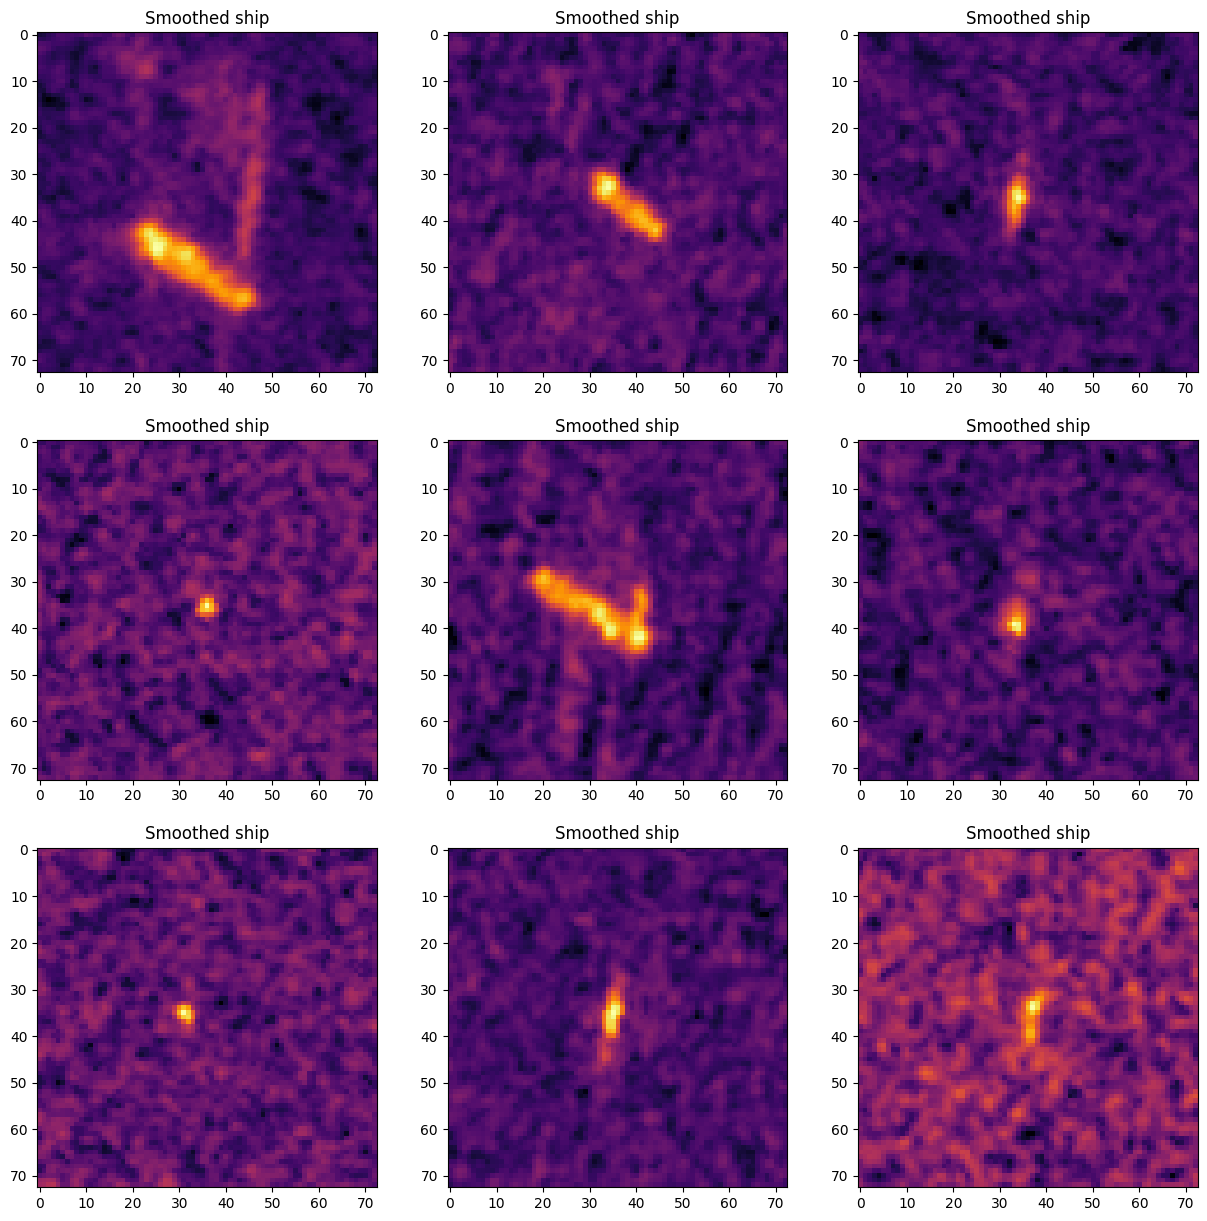

In [16]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed ship')
    
plt.show()

As we might expect, smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters in a cluster/peak finder.

正如我们所预料的那样，平滑处理会模糊特征。然而，它也增强了亮暗区域之间的对比度，因此如果我们希望用它来在聚类/峰值查找器中初始化一些聚类，它可能会非常有用。

### Derivative with Respect to X

An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. This will provide some level of edge detection in the x-direction. I will take the derivatives of the original images.

**相对于 X 的导数**

X 导数通常对于绕 x 轴反转值是反对称的。这将在 x 方向提供一定程度的边缘检测。我将对原始图像进行导数计算。

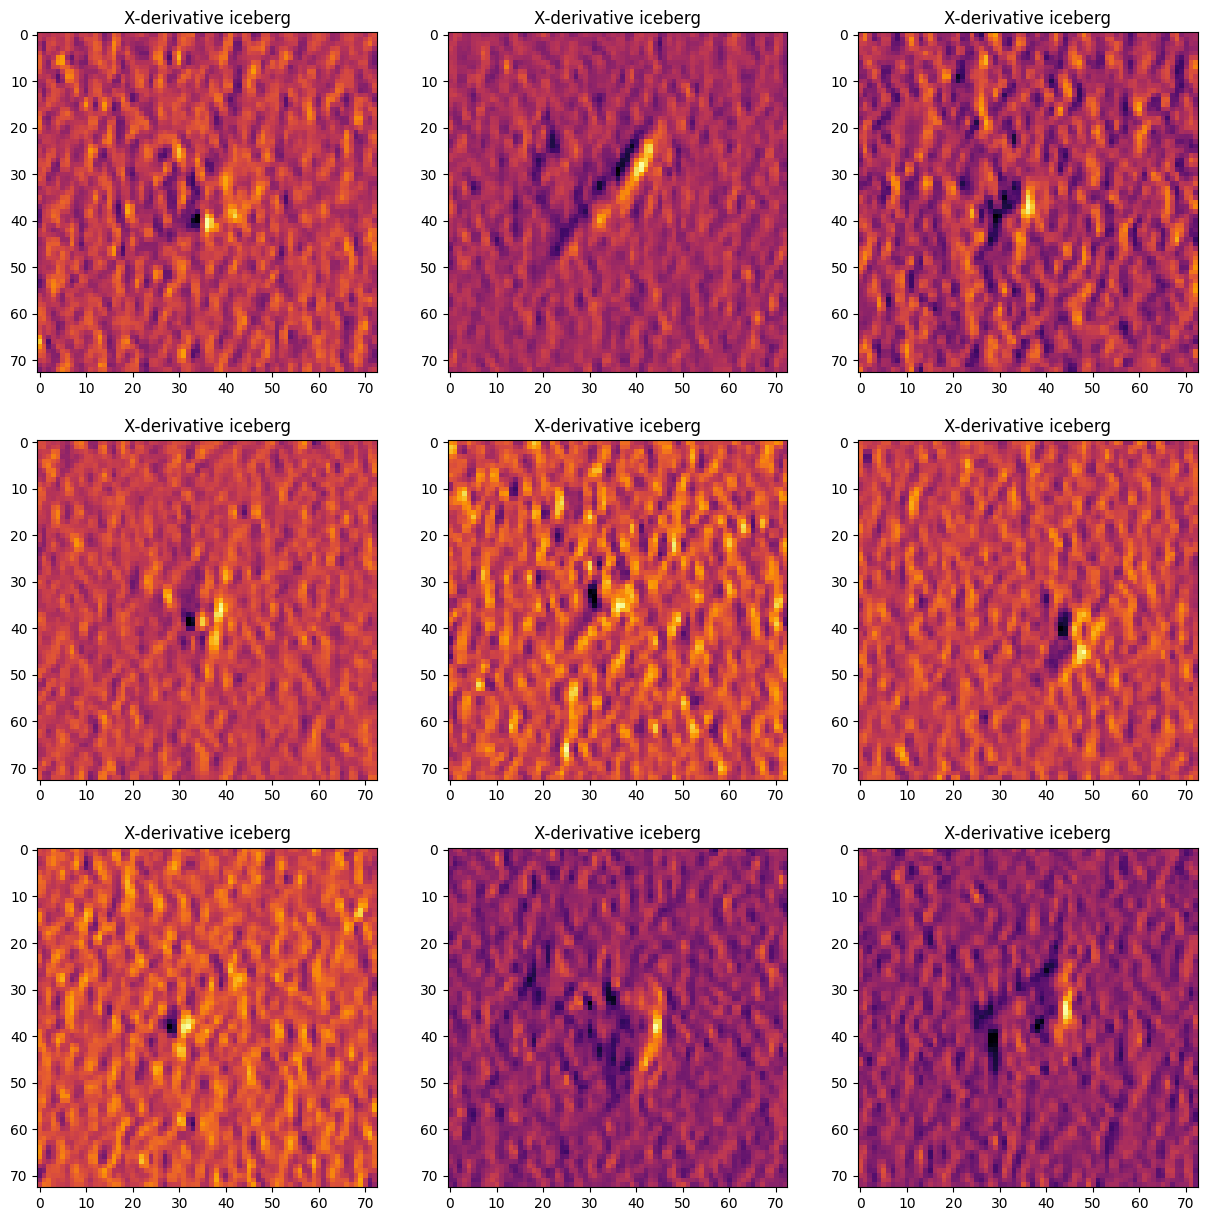

In [17]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative iceberg')
    
plt.show()

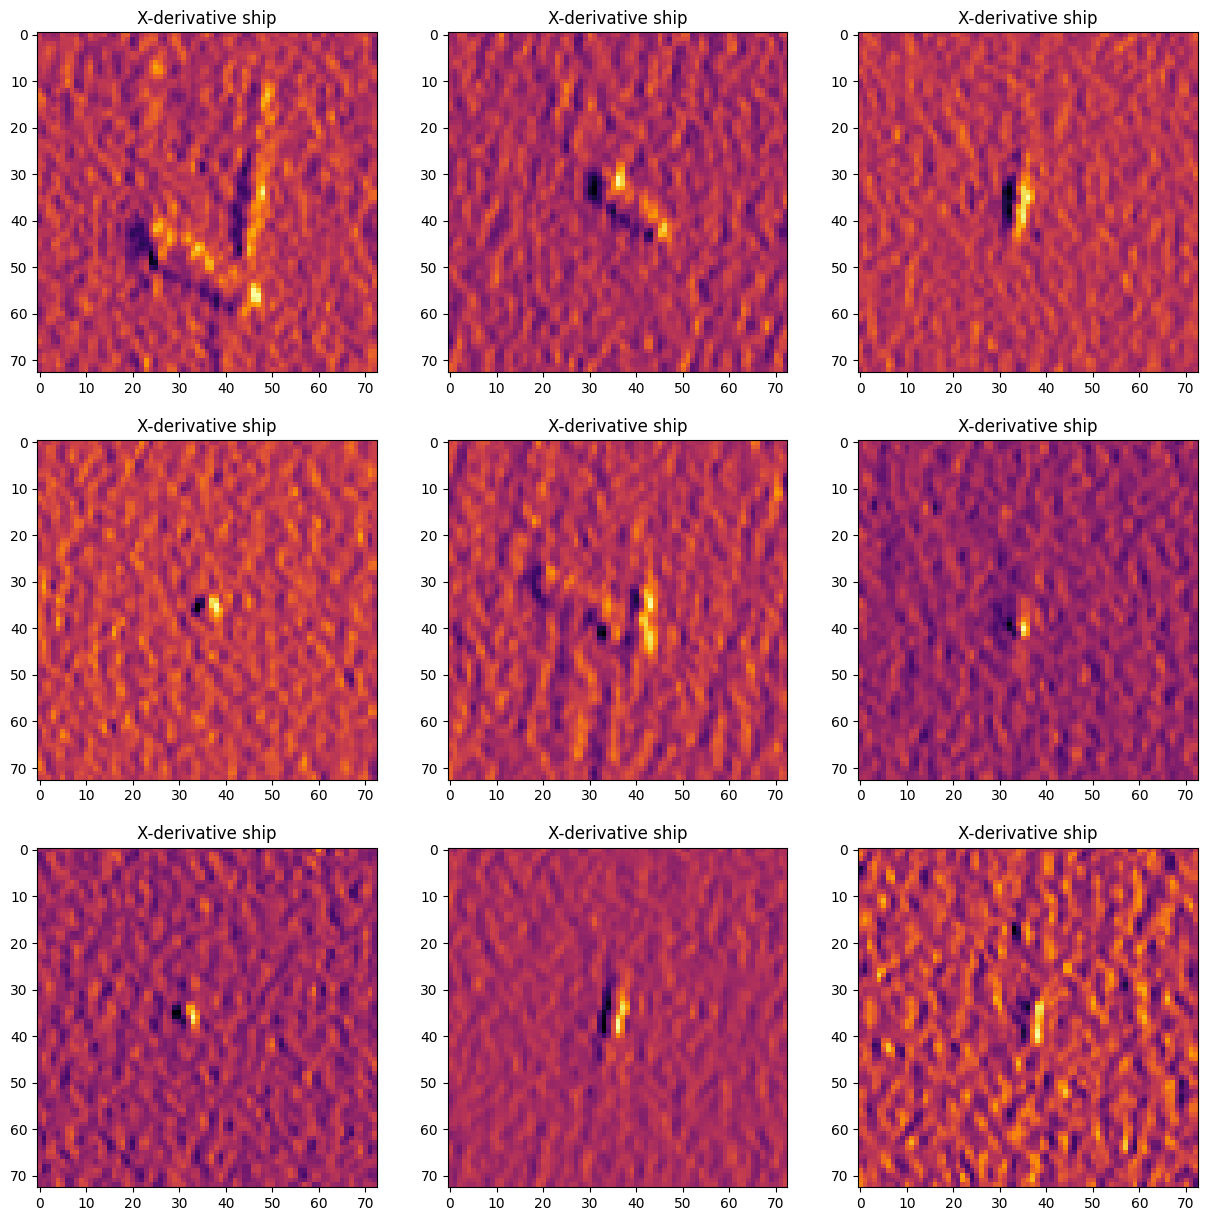

In [18]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative ship')
    
plt.show()

Note that you should see a dark region on the left side of a peak and a bright region on the right. If you look closely enough, you should see that the positions may have changed in all of these transformations. This is because I have chosen not to zero-pad the arrays. The resulting transformed arrays are slightly smaller than the input.

注意，在峰值的左侧你应该看到一个暗区，而在右侧看到一个亮区。如果你仔细观察，你会发现所有这些变换中的位置可能都发生了变化。这是因为我选择不对数组进行零填充。结果，转换后的数组比输入数组略小。

### Gradient Magnitude

It should also be trivial to see how to do a y-derivative. Rather than that, we can look at the magnitude of the gradient. That is, treat the x and y derivatives as a gradient vector at each position and then take the magnitude at each point.


**梯度幅度**

计算 y 导数也应该是简单的。与其这样做，我们可以查看梯度的幅度。即，将 x 和 y 导数视为每个位置的梯度向量，然后在每个点上取其幅度。

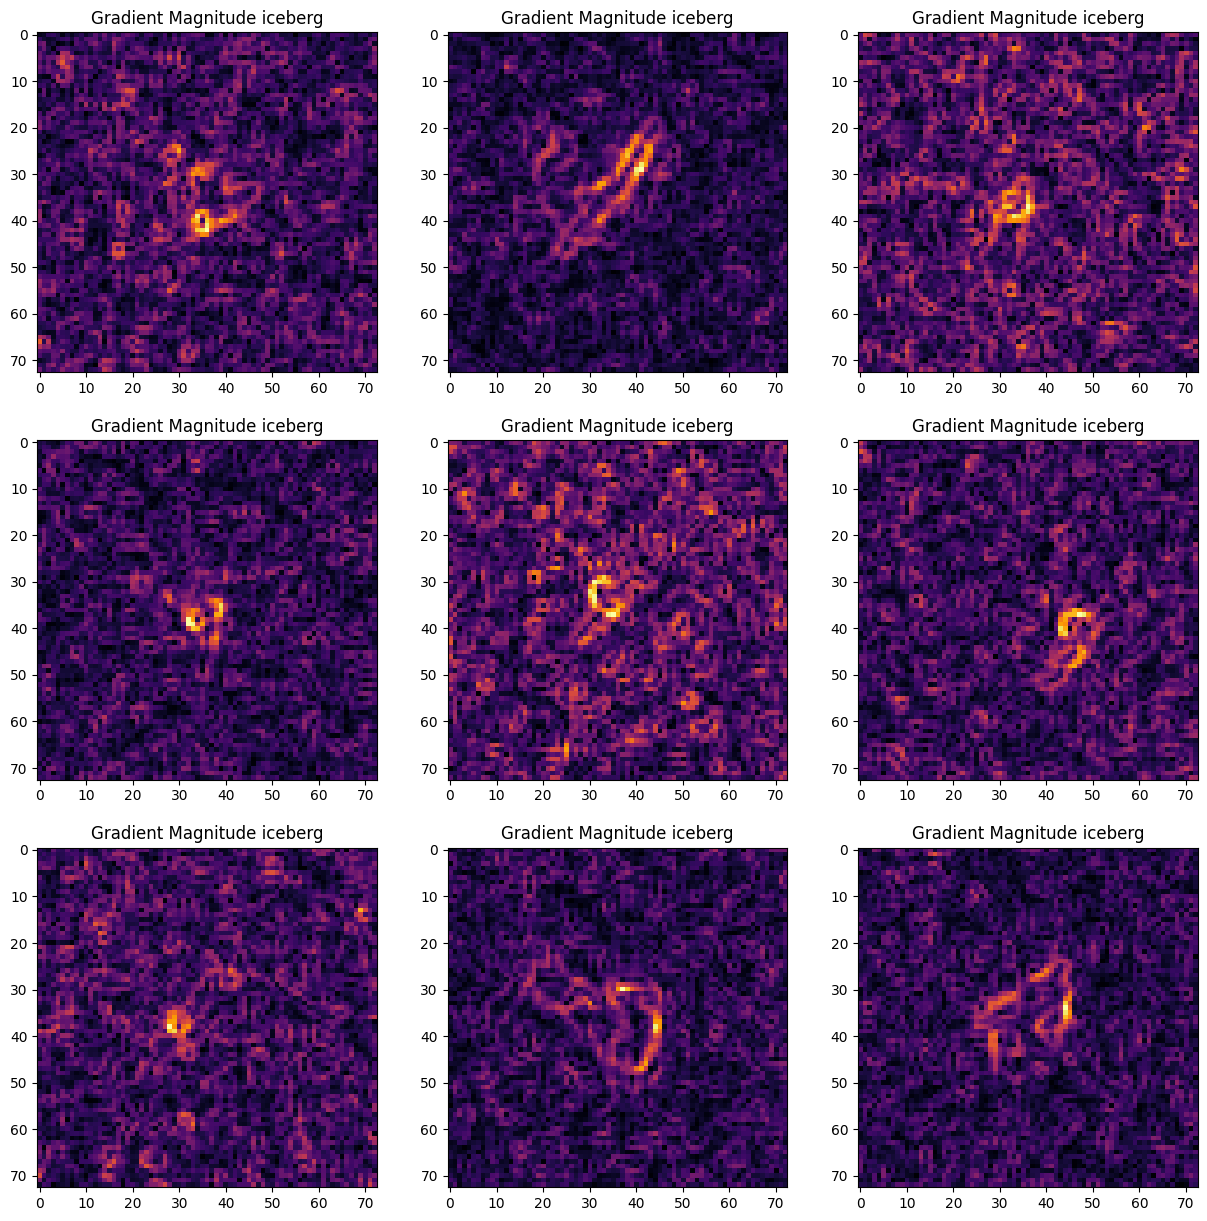

In [19]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude iceberg')
    
plt.show()

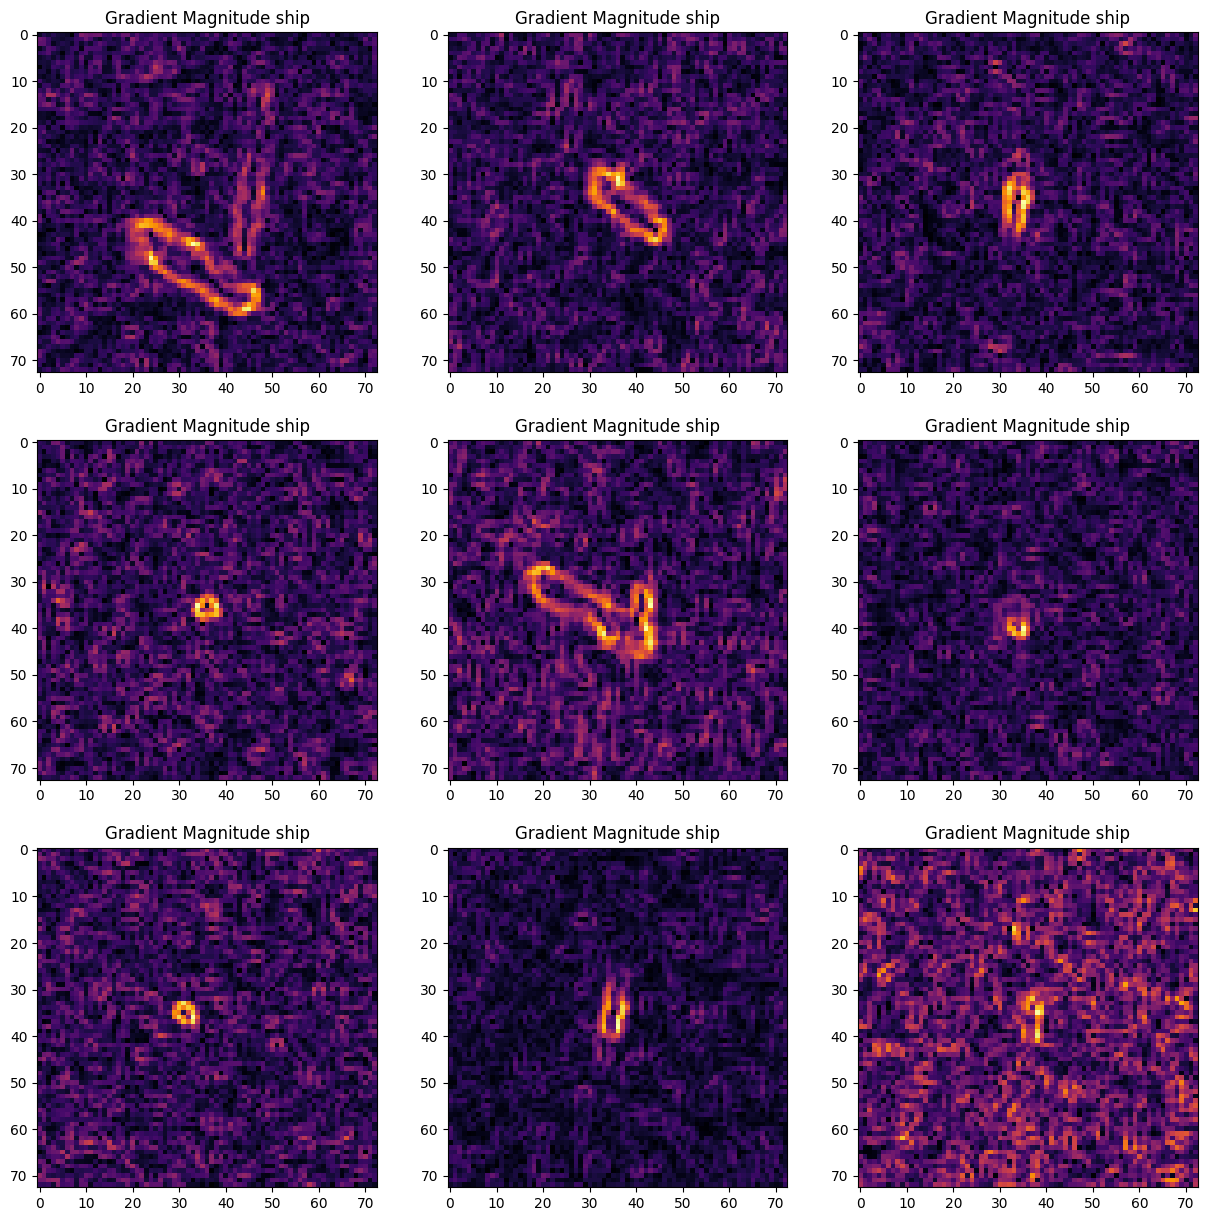

In [20]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude ship')
    
plt.show()

We see interesting circular shapes everywhere in these images. But, the signals look fairly strong. The ships, in particular, show fairly bright edges and most create nice loops. This sort of operator might be useful to put into a more advanced model like a neural net. At the very least, it would be good to compare the results using this against things like the raw and smoothed data. 

我们在这些图像中看到有趣的圆形形状。然而，信号看起来相当强。尤其是船只，显示出相当明亮的边缘，大多数都形成了漂亮的环形。这类算子可能有助于将其引入更高级的模型，例如神经网络。至少，将其结果与原始数据和平滑数据进行比较是有益的。

### Second Derivatives

We can also define a simple second-derivative operator. A 3x3 second derivative should do less smoothing than a 3x3 first derivative, so we might see less contrast between the signal and the background.


**二阶导数**

我们还可以定义一个简单的二阶导数算子。3x3的二阶导数应该比3x3的一阶导数平滑效果更少，因此我们可能会看到信号与背景之间的对比度较低。

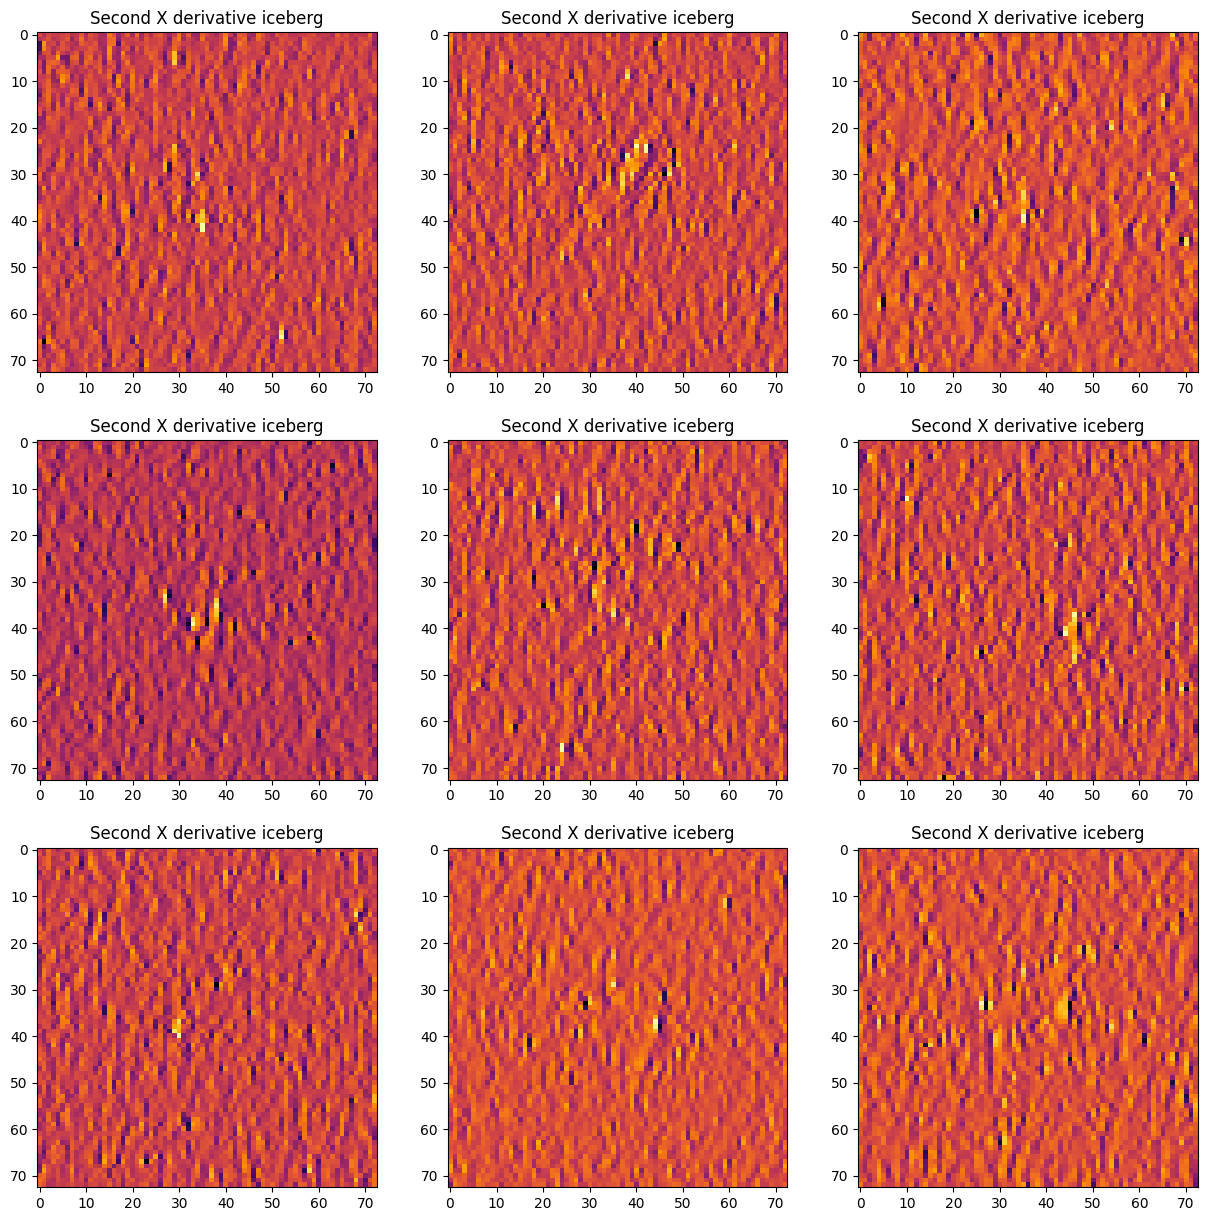

In [21]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative iceberg')
    
plt.show()

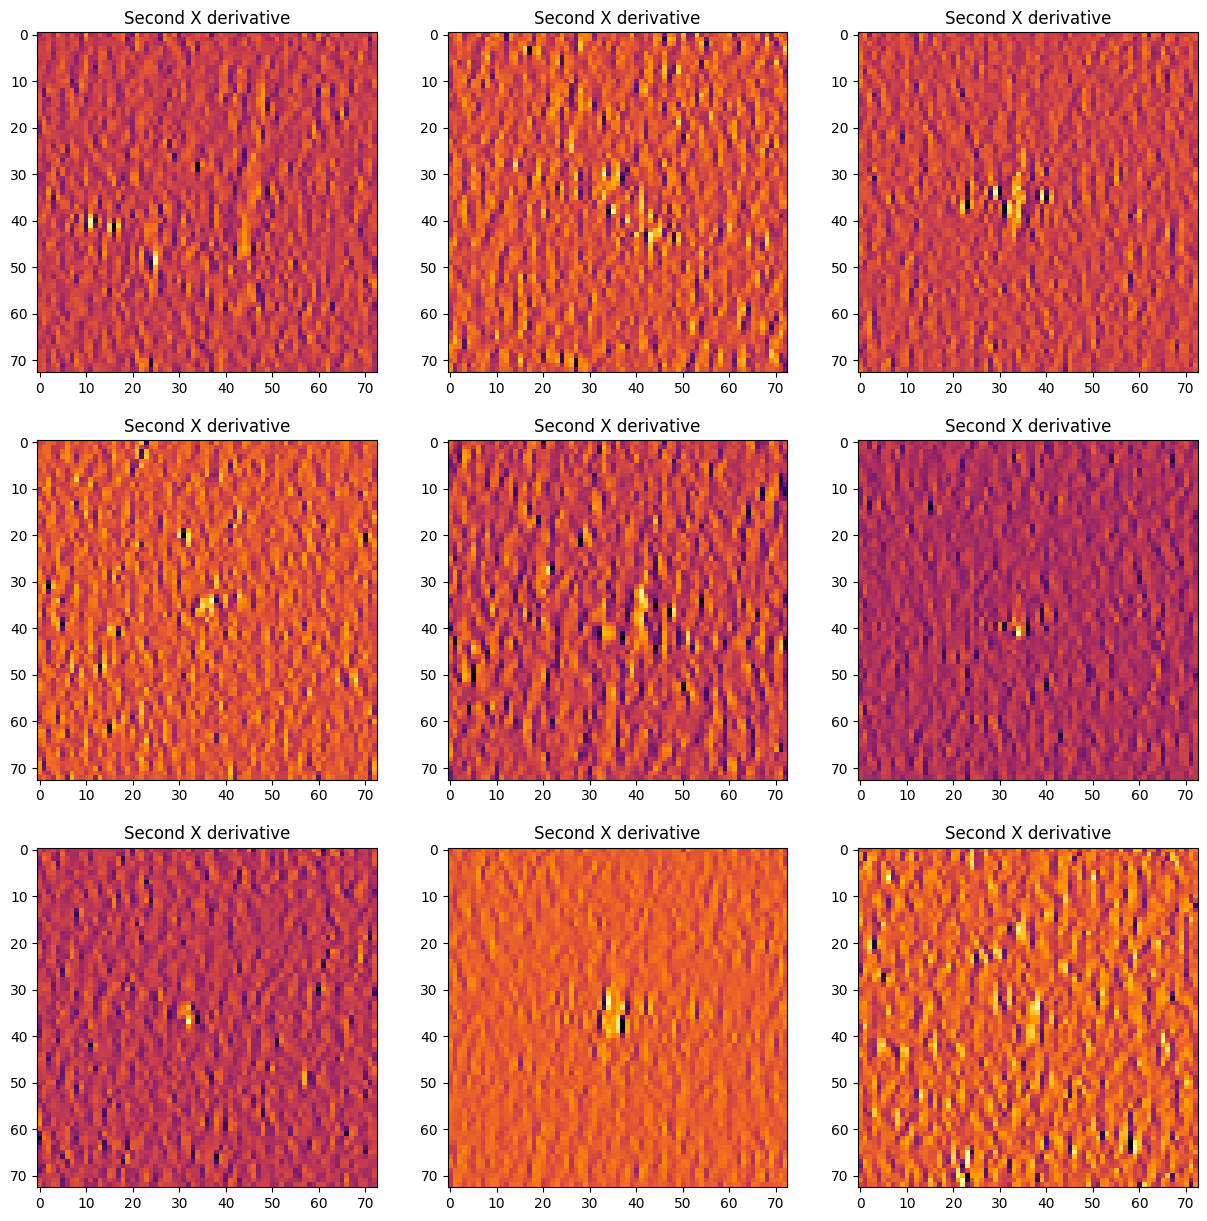

In [22]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

Here, we do see that the signals are not particularly obvious. The ships are a bit more visible, but the noise looks like it may be quite problematic here unless we do more smoothing.

在这里，我们确实看到信号不是特别明显。船只稍微明显一些，但噪声看起来可能会是个大问题，除非我们进行更多的平滑处理。

### Laplacian

The Laplacian operator is just the sum of second derivatives, or the divergence of the gradient.

**拉普拉斯算子**

拉普拉斯算子只是二阶导数的总和，或者说是梯度的散度。

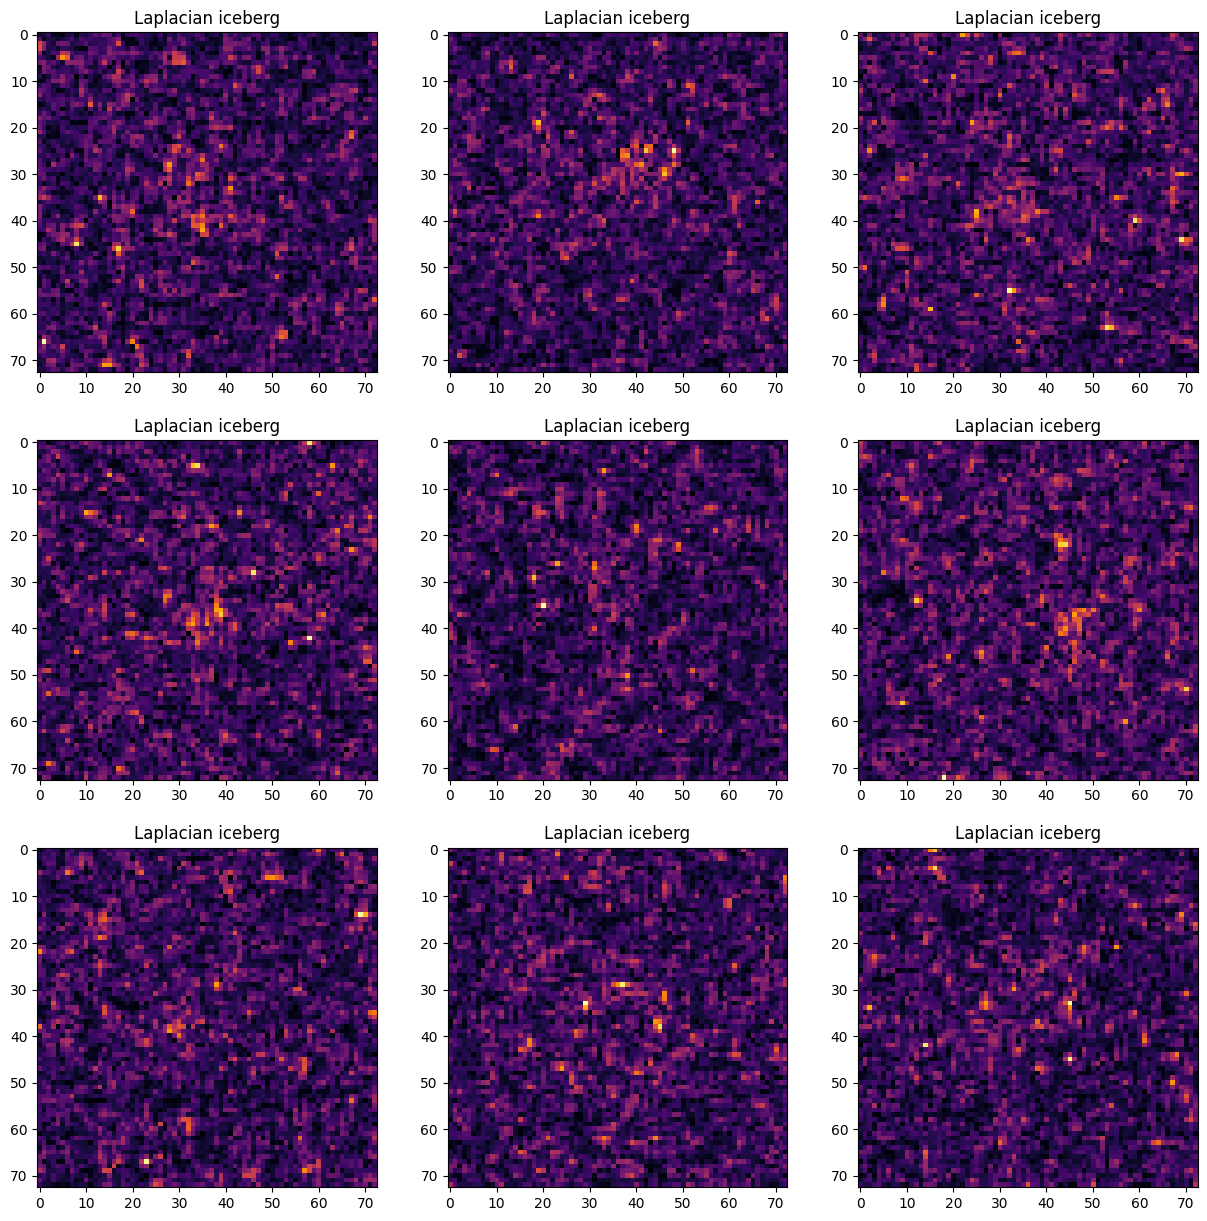

In [23]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian iceberg')
    
plt.show()

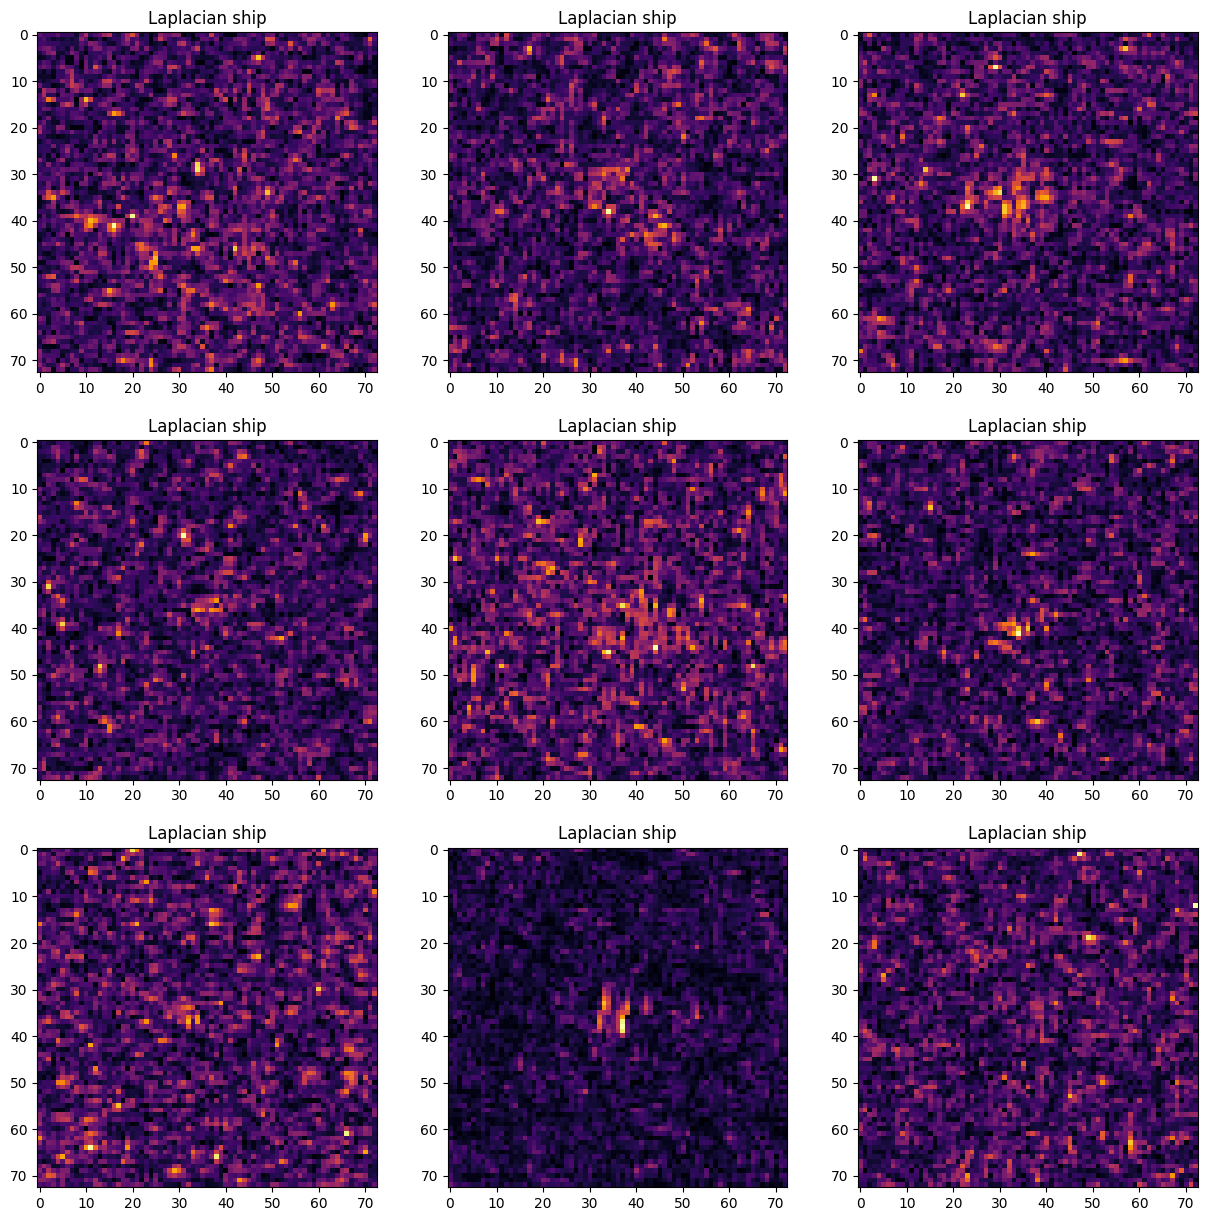

In [24]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian ship')
    
plt.show()

We see interesting vertical and horizontal line features in the Laplacian images, but the signals are mostly difficult to see and split into many small clusters. Again, second derivatives probably require more smoothing to be useful.

我们在拉普拉斯图像中看到了有趣的垂直和水平线特征，但信号大多难以看到，并分裂成许多小簇。再次强调，二阶导数可能需要更多的平滑处理才能变得有用。

### Magnitude of the Curl of Gradient

There are many other things that we can look at. The last one I'll do is the magnitude of the curl of the gradient. For a differentiable function, this actually is supposed to be exactly 0, but for our discrete images, this likely isn't the case. I wouldn't expect this to be useful though.

**梯度旋度的大小**

我们可以查看许多其他内容。最后一个我要做的是梯度旋度的大小。对于可微函数，这实际上应该正好是0，但对于我们的离散图像，可能不是这种情况。不过，我不认为这会有用。

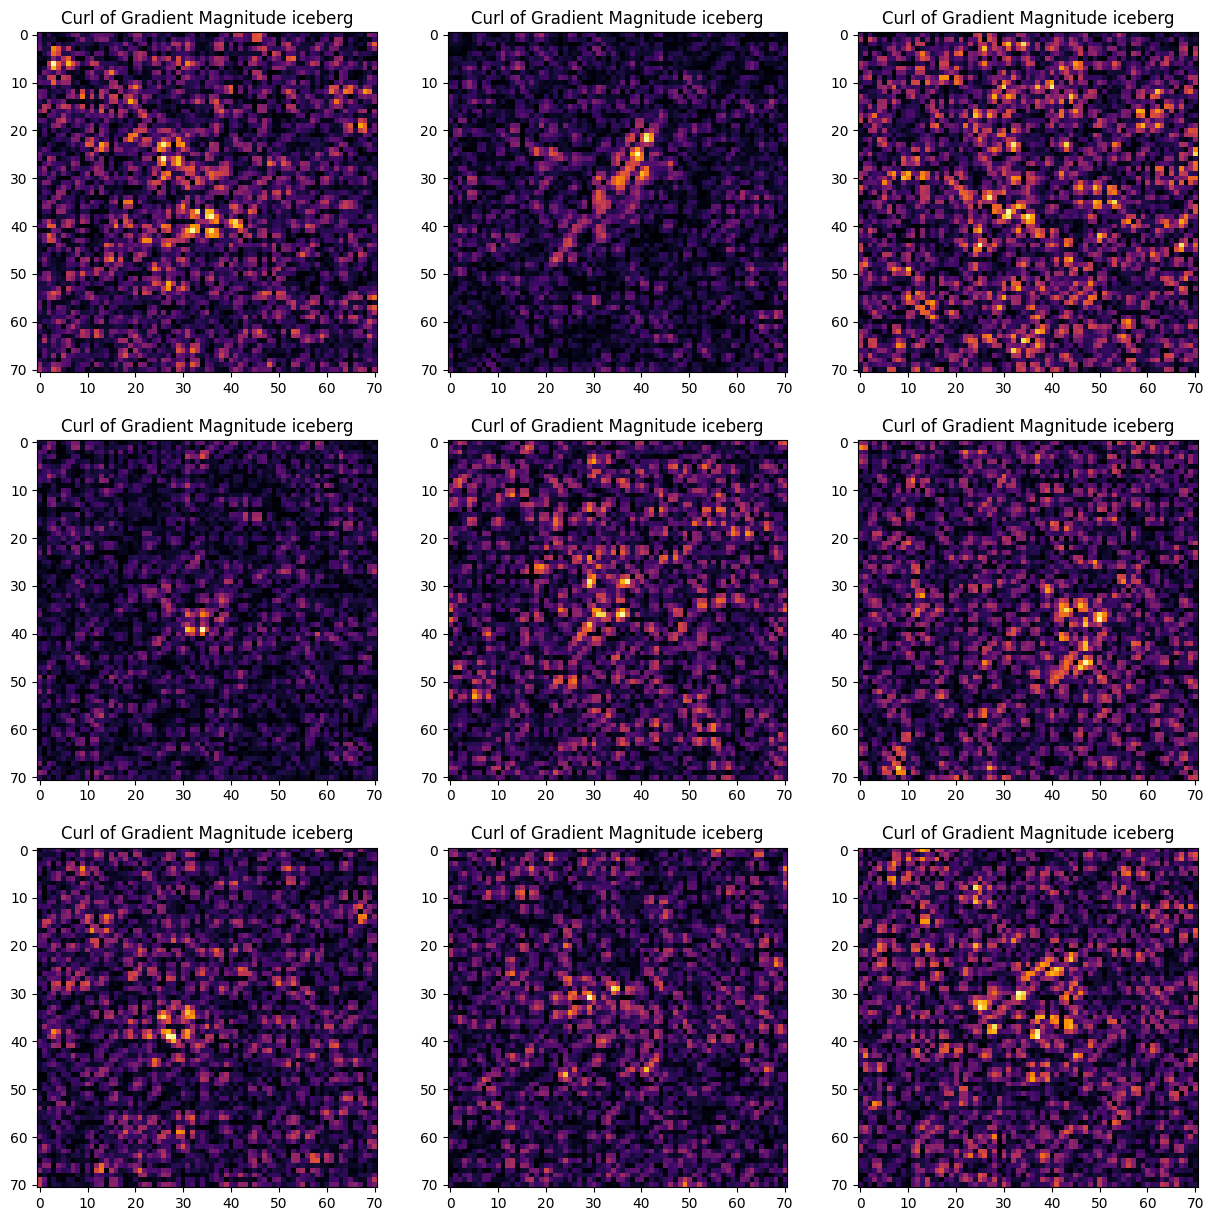

In [25]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude iceberg')
    
plt.show()

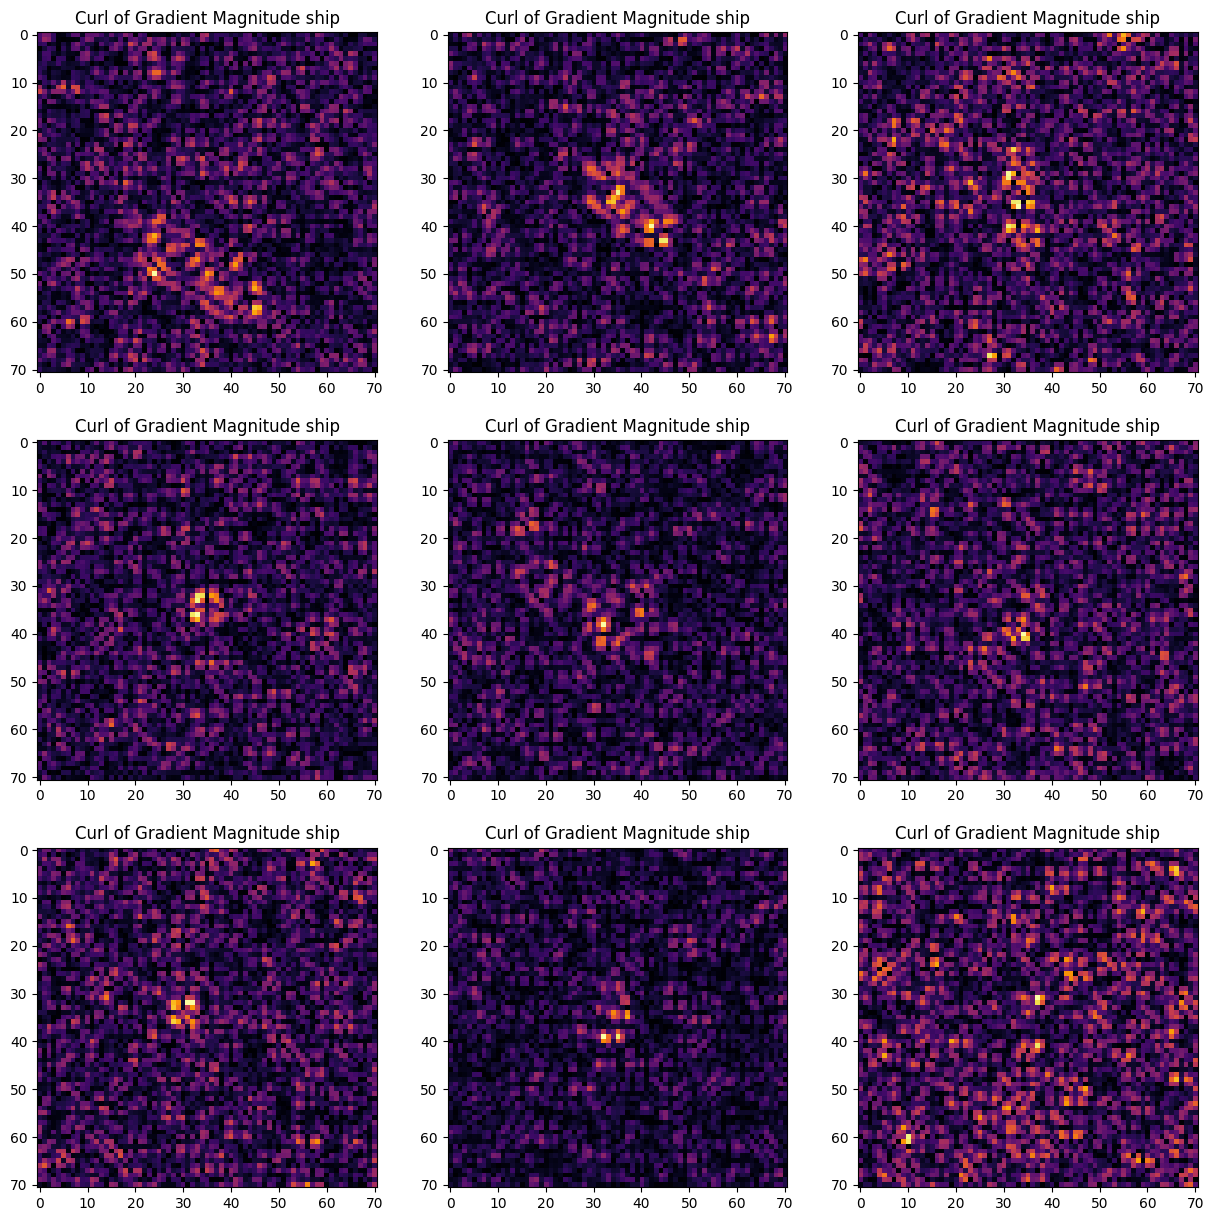

In [26]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,1]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude ship')
    
plt.show()

We can see that as expected, it will at best be of limited usefulness. However, we do get some nice looking images. we see a number of small, separated tiles. Even if it's not useful for analysis, we get some nice textures by transforming the images with this particular transformation.

我们可以看到，正如预期的那样，梯度旋度的大小最多只能提供有限的用途。然而，我们确实得到了几个漂亮的图像。我们看到许多小的、分离的块状区域。即使在分析上不是特别有用，通过这种特定的变换，我们也能获得一些不错的纹理效果。

# Conclusions

We've constructed some global features from the images and found that there are some noticeable differences between icebergs and ships even just from those. However, I would expect that a classifier based only on global statistics will not be very effective.

We've also looked at a number of transformations of the images. Edge detection (gradient)-based methods seem to get some nice features, and smoothing may help out with images with small signal size.

**结论**

我们从图像中构建了一些全局特征，发现即使仅仅基于这些特征，冰山和船只之间也存在一些明显的差异。然而，我预计仅基于全局统计数据的分类器效果不会非常理想。

我们还查看了图像的多种变换。基于边缘检测（梯度）的方法似乎能获得一些不错的特征，而平滑处理可能对那些信号较小的图像有所帮助。

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.ndimage import sobel

# 加载和准备数据
train = pd.read_json("../input/train.json")

X_band_1 = np.array([np.array(band).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).reshape(75, 75) for band in train['band_2']])

# 计算梯度幅度
def gradient_magnitude(band):
    dx = sobel(band, axis=0)
    dy = sobel(band, axis=1)
    return np.sqrt(dx**2 + dy**2)

X_band_1_grad = np.array([gradient_magnitude(band) for band in X_band_1])
X_band_2_grad = np.array([gradient_magnitude(band) for band in X_band_2])

# 将数据展平成一维向量
X_band_1_flat = X_band_1_grad.reshape((X_band_1_grad.shape[0], -1))
X_band_2_flat = X_band_2_grad.reshape((X_band_2_grad.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_train = np.concatenate([X_band_1_flat, X_band_2_flat], axis=1)
y_train = np.array(train['is_iceberg'])

# 将数据集分成训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 训练随机森林分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 在验证集上进行预测
y_pred = clf.predict(X_val)

# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# 加载测试数据
test = pd.read_json("../input/test.json")

# 对测试数据进行预测，需要先将测试数据进行与训练数据相同的处理
X_test_band_1 = np.array([np.array(band).reshape(75, 75) for band in test['band_1']])
X_test_band_2 = np.array([np.array(band).reshape(75, 75) for band in test['band_2']])

# 计算梯度幅度
X_test_band_1_grad = np.array([gradient_magnitude(band) for band in X_test_band_1])
X_test_band_2_grad = np.array([gradient_magnitude(band) for band in X_test_band_2])

# 将测试数据展平成一维向量
X_test_band_1_flat = X_test_band_1_grad.reshape((X_test_band_1_grad.shape[0], -1))
X_test_band_2_flat = X_test_band_2_grad.reshape((X_test_band_2_grad.shape[0], -1))

# 合并 band_1 和 band_2 的数据
X_test = np.concatenate([X_test_band_1_flat, X_test_band_2_flat], axis=1)

# 进行预测
predictions = clf.predict_proba(X_test)[:, 1]  # 取得冰山的概率值

# 生成输出文件
output_df = pd.DataFrame({
    'id': test['id'],
    'is_iceberg': predictions
})

# 将 DataFrame 写入 CSV 文件
output_file = 'predictions.csv'
output_df.to_csv(output_file, index=False)

print(f"Output file '{output_file}' generated successfully.")


Validation Accuracy: 63.55%


ValueError: X has 11250 features, but RandomForestClassifier is expecting 5625 features as input.